In [1]:
from fastai.tabular import *
from fastai.vision import *
from sklearn.model_selection import StratifiedKFold
from fastai.callbacks import *


from custom_nets import *

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
raw_image_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/raw_image/'

# image with skeleton base paths
im_skel_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/im+skeleton/'
skel_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/color_skeleton/skeleton/'

# masked image base path
im_masked_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/maskRCNN_segmentation/masked/'

# dlib points-drawn image base paths
blank_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/dlib/'
im_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/im+dlib/'
skel_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/skel+dlib/'
im_skel_dlib_base_path = '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/dlib_images/im+skel+dlib/'


# csv containing raw image names, yaw-pitch-roll, dlib points, skeleton image names, im+skeleton image names, and masked image names
all_images_YPR_dlib_csv_file_base_path = \
        '/disks/data/paper_projects/selfie_detection/data/DS_224_all_features_no_duplicates/CSVs/with_test_set/'

In [4]:
# d = {3:'Hello', 5:'No'}
# d[3]

In [5]:
class_names = ['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie']

image_paths = {'im'             : [raw_image_base_path],               'skeleton'       : [skel_base_path],      'im_skeleton'     : [im_skel_base_path],      'im_masked'     : [im_masked_base_path],
               'im,YPR'         : [raw_image_base_path],               'im_skeleton,YPR': [im_skel_base_path],   'skeleton,YPR'    : [skel_base_path], 
               'im_dlib,YPR'    : [im_dlib_base_path],                 'skel_dlib,YPR'  : [skel_dlib_base_path], 'im_skel_dlib,YPR': [im_skel_dlib_base_path], 'blank_dlib,YPR': [blank_dlib_base_path],
               'im,skeleton,YPR': [raw_image_base_path, skel_base_path]}

custom_network_architectures = {'ImageTabularModel_YPR'     : ImageTabularModel_YPR(3, [models.resnet34]), 
                                'ImageTabularModel_YPR_dlib': ImageTabularModel_YPR(139, [models.resnet34])}


network_architectures = {'im'              : (models.resnet50, models.densenet201, models.vgg19_bn),
                         'im,YPR'          : (custom_network_architectures['ImageTabularModel_YPR'],),
                         'im_skeleton,YPR' : (custom_network_architectures['ImageTabularModel_YPR'],),
                         'im_masked'       : (models.resnet50,),
                        }


network_architecture_names = { 'im'              : ('resnet50', 'densenet201', 'vgg19_bn'),
                               'im,YPR'          : ('ImageTabularModel_YPR',),
                               'im_skeleton,YPR' : ('ImageTabularModel_YPR',),
                               'im_masked'       : ('resnet50',),
                              }


class_configs = {'selfie__vs__no_selfie'                       : (('selfie',),('non_selfie',)), 
                 'selfie_mirror__vs__non_selfie_non_mirrror'   : (('selfie','mirror_selfie'),('non_selfie','non_mirror_selfie')), 
                 'mirror__vs__non_mirrror'                     : (('mirror_selfie',),('non_mirror_selfie',))}

feature_configs = {'im,skeleton,YPR'  : {'image_data':('im_name','skeleton'),  'num_data':['yaw','pitch','roll']},
                   'im'               : {'image_data':('im_name',),            'num_data':[]},
                   'skeleton'         : {'image_data':('skeleton',),           'num_data':[]},                   
                   'im_skeleton'      : {'image_data':('im_skeleton',),        'num_data':[]},
                   'im_masked'        : {'image_data':('im_masked',),          'num_data':[]},
                   'im,YPR'           : {'image_data':('im_name',),            'num_data':['yaw','pitch','roll']},
                   'im_skeleton,YPR'  : {'image_data':('im_skeleton',),        'num_data':['yaw','pitch','roll']},
                   'skeleton,YPR'     : {'image_data':('skeleton',),           'num_data':['yaw','pitch','roll']},                   
                   'im_dlib,YPR'      : {'image_data':('im_dlib',),            'num_data':['yaw','pitch','roll']},
                   'skel_dlib,YPR'    : {'image_data':('skel_dlib',),          'num_data':['yaw','pitch','roll']},
                   'im_skel_dlib,YPR' : {'image_data':('im_skel_dlib',),       'num_data':['yaw','pitch','roll']},
                   'blank_dlib,YPR'   : {'image_data':('dlib',),               'num_data':['yaw','pitch','roll']},
                  }


# feature          -> column name in DF
#---------------------------------------
# raw image        -> im_name
# skeleton only    -> skeleton
# image+skeleton   -> im_skeleton
# masked image     -> im_masked
# blank im+dlib    -> dlib
# raw image+dlib   -> im_dlib
# skeleton+dlib    -> skel_dlib
# im+sleleton+dlib -> im_skel_dlib
# yaw              -> yaw
# pitch            -> pitch
# roll             -> roll
# dlib pts         -> x_1, y_1, ... , x_68, y_68


# csv.columns

# Configuration

In [6]:
feature_config_label = 'im_masked'
net_arch_idx = 0  # change index to select a different architecture/backbone 

class_config = class_configs['selfie__vs__no_selfie'] # 'selfie_vs_no_selfie' or 'selfie__mirror_vs_non_selfie___non_mirrror'
#class_config = class_configs['selfie_mirror__vs__non_selfie_non_mirrror']
#class_config = class_configs['mirror__vs__non_mirrror']
feature_config = feature_configs[feature_config_label]
network_architecture = network_architectures[feature_config_label][net_arch_idx] 
network_architecture_name = network_architecture_names[feature_config_label][net_arch_idx]

is_testing = False

# Load csvs into per-label dataframes

In [7]:
class_dataframes = {}

for class_name in class_names:
    csv = pd.read_csv(all_images_YPR_dlib_csv_file_base_path+class_name+'_with_testet.csv')
    #csv.insert(0, column = 'class_label',value = len(csv.index)*[f"{class_name}"])
    for i, im_feature_col in enumerate(feature_config['image_data']):        
        csv[f'path_{i:02d}'] = csv.class_label + '/' + csv[im_feature_col]
        #csv = csv.drop(['filename'], axis = 1)
    
    class_dataframes[class_name] = csv
        #print(csv.columns)
        #csv.head()

In [8]:
csv.head()

,class_label,im_name,x_min,y_min,x_max,y_max,confidence_score,yaw,pitch,roll,...,y_68,skeleton,im_skeleton,im_masked,dlib,im_dlib,skel_dlib,im_skel_dlib,is_test,path_00
0,non_mirror_selfie,21942668215_6e85ce854d_c.jpg,113.444016,57.137173,182.754196,132.164490,NaN,-36.658585,-17.108208,2.841003,...,82,21942668215_6e85ce854d_c.jpg_skeleton.jpg,21942668215_6e85ce854d_c.jpg_im_skeleton.jpg,21942668215_6e85ce854d_c.jpg_masked.jpg,21942668215_6e85ce854d_c_dlib_only.jpg,21942668215_6e85ce854d_c_dlib.jpg,21942668215_6e85ce854d_c.jpg_skeleton_dlib.jpg,21942668215_6e85ce854d_c.jpg_im_skeleton_dlib.jpg,0,non_mirror_selfie/21942668215_6e85ce854d_c.jpg...
1,non_mirror_selfie,google_faces__110618_000108.jpg,88.976105,53.586029,194.349915,180.566544,NaN,-12.694344,-15.782524,11.781647,...,112,google_faces__110618_000108.jpg_skeleton.jpg,google_faces__110618_000108.jpg_im_skeleton.jpg,google_faces__110618_000108.jpg_masked.jpg,google_faces__110618_000108_dlib_only.jpg,google_faces__110618_000108_dlib.jpg,google_faces__110618_000108.jpg_skeleton_dlib.jpg,google_faces__110618_000108.jpg_im_skeleton_dl...,0,non_mirror_selfie/google_faces__110618_000108....
2,non_mirror_selfie,google_medium_shot_face_010112_000538.jpg,103.273010,71.900574,181.120209,234.320435,NaN,7.867615,4.090118,8.581444,...,131,google_medium_shot_face_010112_000538.jpg_skel...,google_medium_shot_face_010112_000538.jpg_im_s...,google_medium_shot_face_010112_000538.jpg_mask...,google_medium_shot_face_010112_000538_dlib_onl...,google_medium_shot_face_010112_000538_dlib.jpg,google_medium_shot_face_010112_000538.jpg_skel...,google_medium_shot_face_010112_000538.jpg_im_s...,0,non_mirror_selfie/google_medium_shot_face_0101...
3,non_mirror_selfie,google_faces__251213_000068.jpg,130.480408,13.828512,170.518005,57.133636,NaN,-2.895096,-21.899353,-0.638931,...,39,google_faces__251213_000068.jpg_skeleton.jpg,google_faces__251213_000068.jpg_im_skeleton.jpg,google_faces__251213_000068.jpg_masked.jpg,google_faces__251213_000068_dlib_only.jpg,google_faces__251213_000068_dlib.jpg,google_faces__251213_000068.jpg_skeleton_dlib.jpg,google_faces__251213_000068.jpg_im_skeleton_dl...,1,non_mirror_selfie/google_faces__251213_000068....
4,non_mirror_selfie,24146502870_915723d44d_c.jpg,94.539200,51.739666,152.880386,164.739883,NaN,-28.479874,-12.382072,3.665863,...,100,24146502870_915723d44d_c.jpg_skeleton.jpg,24146502870_915723d44d_c.jpg_im_skeleton.jpg,24146502870_915723d44d_c.jpg_masked.jpg,24146502870_915723d44d_c_dlib_only.jpg,24146502870_915723d44d_c_dlib.jpg,24146502870_915723d44d_c.jpg_skeleton_dlib.jpg,24146502870_915723d44d_c.jpg_im_skeleton_dlib.jpg,1,non_mirror_selfie/24146502870_915723d44d_c.jpg...


In [9]:
[class_dataframe.shape for _, class_dataframe in class_dataframes.items()], class_dataframes.keys()

([(1216, 159), (1199, 159), (1171, 159), (1212, 159)],
 dict_keys(['selfie', 'non_selfie', 'mirror_selfie', 'non_mirror_selfie']))

In [10]:
class_config
class_01_labels = class_config[0]
class_02_labels = class_config[1]

class_01_labels, class_02_labels 

(('selfie',), ('non_selfie',))

In [11]:
# class_config[0]

In [12]:
class_01_df = class_dataframes[class_01_labels[0]]
for i,pos_class_label in enumerate(class_01_labels[1:]):
    class_01_df = class_01_df.append(class_dataframes[class_01_labels[i]])

class_01_df['class_label'] = class_01_labels[0]    
    
class_02_df = class_dataframes[class_02_labels[0]]    
for i,neg_class_label in enumerate(class_02_labels[1:]):
    class_02_df = class_02_df.append(class_dataframes[class_02_labels[i]])
        
class_02_df['class_label'] = class_02_labels[0]

#selfie_df = class_dataframes['selfie'].sample(n=len(class_dataframes['non_selfie'].index), replace=False, random_state=4, axis=0)

print(class_01_df.shape, class_02_df.shape)
print(set(class_01_df.class_label), set(class_02_df.class_label))
#newdf = class_dataframes['selfie'].copy().append(class_dataframes['non_selfie'])
all_class_df = class_01_df.append(class_02_df)

(1216, 159) (1199, 159)
{'selfie'} {'non_selfie'}


In [13]:
print(all_class_df.shape)
all_class_df.head()

(2415, 159)


,class_label,im_name,x_min,y_min,x_max,y_max,confidence_score,yaw,pitch,roll,...,y_68,skeleton,im_skeleton,im_masked,dlib,im_dlib,skel_dlib,im_skel_dlib,is_test,path_00
0,selfie,google_selfie_face_240614_000455.jpg,89.165497,30.651741,197.377838,229.067047,NaN,-5.471474,-10.517761,2.510727,...,137,google_selfie_face_240614_000455.jpg_skeleton.jpg,google_selfie_face_240614_000455.jpg_im_skelet...,google_selfie_face_240614_000455.jpg_masked.jpg,google_selfie_face_240614_000455_dlib_only.jpg,google_selfie_face_240614_000455_dlib.jpg,google_selfie_face_240614_000455.jpg_skeleton_...,google_selfie_face_240614_000455.jpg_im_skelet...,0,selfie/google_selfie_face_240614_000455.jpg_ma...
1,selfie,selfie_mshah_0000260.jpg,80.503311,81.839630,205.567429,242.020813,NaN,-1.656120,-22.516785,-5.354843,...,158,selfie_mshah_0000260.jpg_skeleton.jpg,selfie_mshah_0000260.jpg_im_skeleton.jpg,selfie_mshah_0000260.jpg_masked.jpg,selfie_mshah_0000260_dlib_only.jpg,selfie_mshah_0000260_dlib.jpg,selfie_mshah_0000260.jpg_skeleton_dlib.jpg,selfie_mshah_0000260.jpg_im_skeleton_dlib.jpg,0,selfie/selfie_mshah_0000260.jpg_masked.jpg
2,selfie,google_selfie_face_221214_000342.jpg,99.930939,18.002396,225.676270,225.900085,NaN,-4.957504,9.064941,-0.161568,...,131,google_selfie_face_221214_000342.jpg_skeleton.jpg,google_selfie_face_221214_000342.jpg_im_skelet...,google_selfie_face_221214_000342.jpg_masked.jpg,google_selfie_face_221214_000342_dlib_only.jpg,google_selfie_face_221214_000342_dlib.jpg,google_selfie_face_221214_000342.jpg_skeleton_...,google_selfie_face_221214_000342.jpg_im_skelet...,1,selfie/google_selfie_face_221214_000342.jpg_ma...
3,selfie,selfie_mshah_0003414.jpg,93.739922,49.757812,223.862854,229.142426,NaN,7.558365,-12.061974,3.384087,...,144,selfie_mshah_0003414.jpg_skeleton.jpg,selfie_mshah_0003414.jpg_im_skeleton.jpg,selfie_mshah_0003414.jpg_masked.jpg,selfie_mshah_0003414_dlib_only.jpg,selfie_mshah_0003414_dlib.jpg,selfie_mshah_0003414.jpg_skeleton_dlib.jpg,selfie_mshah_0003414.jpg_im_skeleton_dlib.jpg,1,selfie/selfie_mshah_0003414.jpg_masked.jpg
4,selfie,selfie_mshah_0019154.jpg,100.942413,5.262352,217.760498,154.478882,NaN,-0.130676,-6.205650,-0.251312,...,90,selfie_mshah_0019154.jpg_skeleton.jpg,selfie_mshah_0019154.jpg_im_skeleton.jpg,selfie_mshah_0019154.jpg_masked.jpg,selfie_mshah_0019154_dlib_only.jpg,selfie_mshah_0019154_dlib.jpg,selfie_mshah_0019154.jpg_skeleton_dlib.jpg,selfie_mshah_0019154.jpg_im_skeleton_dlib.jpg,0,selfie/selfie_mshah_0019154.jpg_masked.jpg


In [14]:
from training import *

all_class_df = all_class_df.reset_index(drop = True)

train_val_df = all_class_df[all_class_df['is_test']==0]
train_val_idxs = train_val_df.index.values

test_df = all_class_df[all_class_df['is_test']==1]
test_idxs = test_df.index.values

train_val_df = train_val_df.reset_index(drop = True)
test_df = test_df.reset_index(drop = True)

In [15]:
# # verify indices are computed correctly
# set(all_class_df.iloc[train_val_idxs].is_test.values), set(all_class_df.iloc[test_idxs].is_test.values)

[[0.952991 0.047009]
 [0.371795 0.628205]]
[[223  11]
 [ 87 147]]
[[0.952991 0.047009]
 [0.371795 0.628205]]
[[0.952991 0.047009]
 [0.371795 0.628205]]


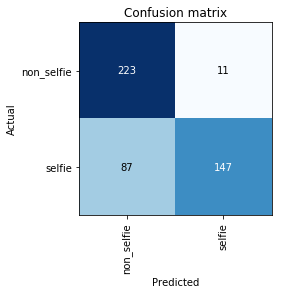

In [16]:
print("train+val set size:",len(train_val_df.index))
print("test set size:",len(test_df.index))


print('---------------------------------------------------------------------------------------')
print('Using architecture:', network_architecture_name)
print('---------------------------------------------------------------------------------------')

is_testing = True

if not is_testing:

    n_folds = 10

    skf = StratifiedKFold( n_splits = n_folds, shuffle=True, random_state=1)

    fold = 0
    learners = []

    for train_idxs, val_idxs in skf.split(train_val_df.index, train_val_df['class_label']):

        fold += 1

        print('======================================================')
        print(f'================= fold {fold} ===========================')

        savefile_suffix = '_CV_fold_{fold:02d}'
        if(len(feature_config['num_data'])>0): # Hybrid network
            learn = train_hybrid(train_idxs, val_idxs, train_val_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix )
        else:
            learn = train_cnn(train_idxs, val_idxs, train_val_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix )

        learners.append(learn)

        if(fold==5):
            break

else:
    
    learners = []
    savefile_suffix = 'test'
    if(len(feature_config['num_data'])>0): # Hybrid network
        learn = train_hybrid(train_val_idxs, test_idxs, all_class_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix, do_callbacks = not is_testing )
    else:
        learn = train_cnn(train_val_idxs, test_idxs, all_class_df, image_paths, feature_config_label, feature_config, network_architecture, savefile_suffix, do_callbacks = not is_testing )
    
    learners.append(learn)       
    
    
# results    
confusion_matrices = []
for learn in learners:
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()

    confusion_mat = interp.confusion_matrix()
    confusion_matrices.append(confusion_mat)
    print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))


for confusion_mat in confusion_matrices:
    print(confusion_mat)
    print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))

# plt.figure()
# interp.plot_confusion_matrix()

# confusion_mat = interp.confusion_matrix()
# print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))

# average per-class accuracy
summed_conf_mat = np.array(confusion_matrices).sum(axis=0).squeeze()
print(summed_conf_mat/np.sum(summed_conf_mat, axis = 1).reshape(-1,1))
    

In [17]:
# #loss, acc = learn.validate()
# #print(acc)

# data = (ImageList.from_df(all_class_df, image_paths[feature_config_label][0], cols=f'path_{0:02d}')
#                                 .split_by_idxs(train_val_idxs, test_idxs)
#                                 .label_from_df(cols='class_label')
#                                 .transform(get_transforms())
#                                 .databunch(bs=32) 
#                             ).normalize(imagenet_stats)

# type(data)

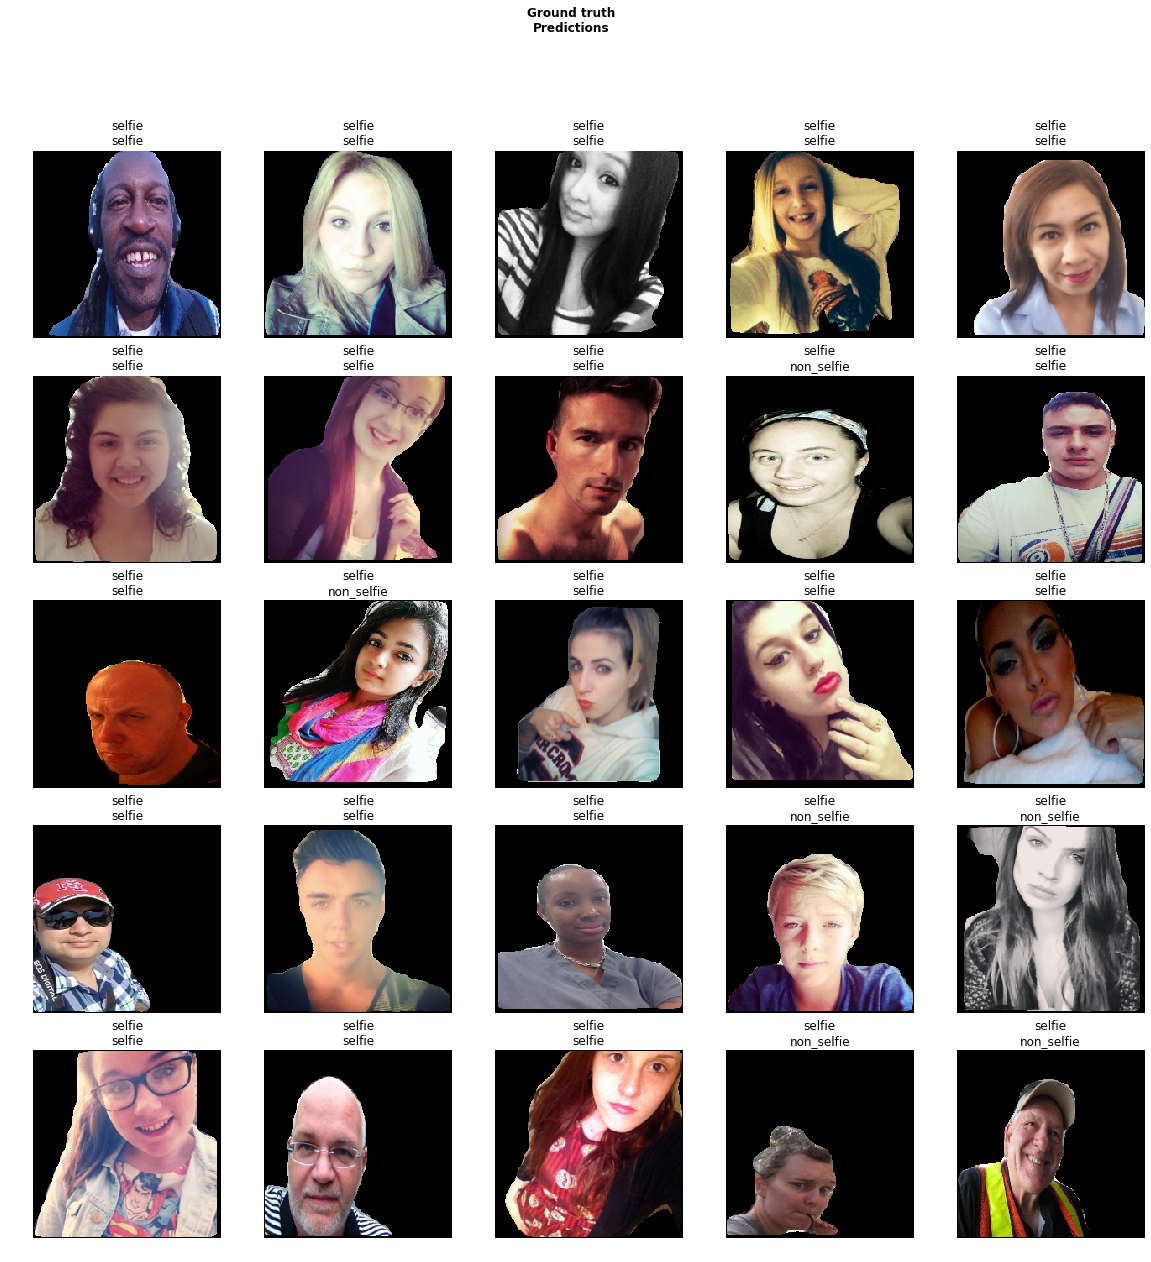

In [18]:
learn.show_results()

[[0.952991 0.047009]
 [0.371795 0.628205]]
[[223  11]
 [ 87 147]]
[[0.952991 0.047009]
 [0.371795 0.628205]]
[[0.952991 0.047009]
 [0.371795 0.628205]]


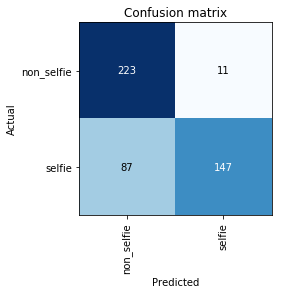

_cl_int_plot_top_losses [source] [test] _cl_int_plot_top_losses ( k , largest = True , figsize = (12, 12) , heatmap : bool = None , heatmap_thresh : int = 16 , return_fig : bool = None ) → Optional [ Figure ] 
 
 × No tests found for _cl_int_plot_top_losses . To contribute a test please refer to this guide and this discussion . Show images in top_losses along with their prediction, actual, loss, and probability of actual class. 
 Show in docs

In [19]:
# results    
confusion_matrices = []
for learn in learners:
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()

    confusion_mat = interp.confusion_matrix()
    confusion_matrices.append(confusion_mat)
    print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))


for confusion_mat in confusion_matrices:
    print(confusion_mat)
    print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))

# plt.figure()
# interp.plot_confusion_matrix()

# confusion_mat = interp.confusion_matrix()
# print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))

# average per-class accuracy
summed_conf_mat = np.array(confusion_matrices).sum(axis=0).squeeze()
print(summed_conf_mat/np.sum(summed_conf_mat, axis = 1).reshape(-1,1))
    

doc(interp.plot_top_losses)

In [20]:

interp = ClassificationInterpretation.from_learner(learn)

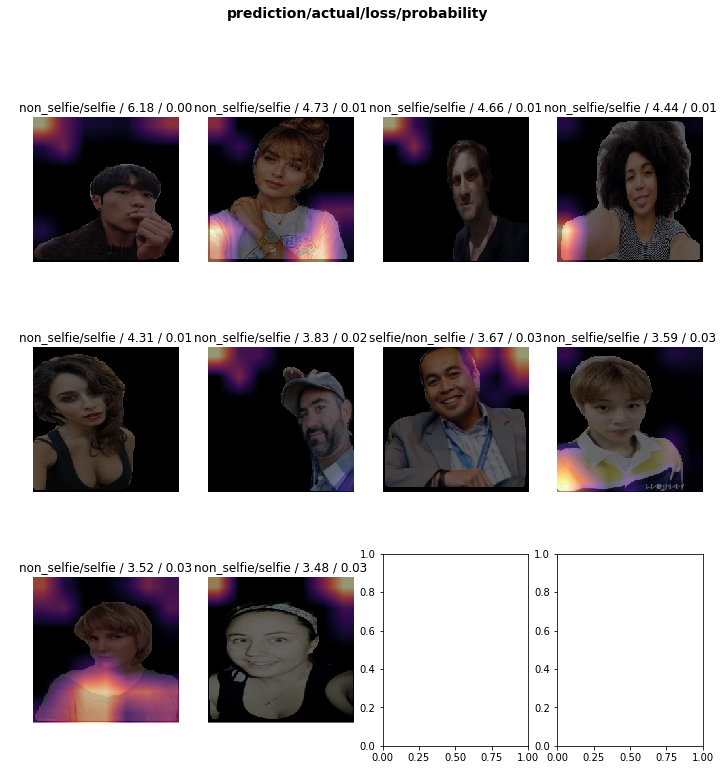

In [21]:
interp.plot_top_losses(k=10)

In [22]:
interp.top_losses().values.shape

torch.Size([468])

In [23]:
# len(data.train_ds)

In [24]:
# len(data.valid_ds)

In [25]:
# data.classes

In [26]:
# # K-fold cross validation

# image_paths[feature_config_label][0]

# train_val_df.head()

In [27]:
import fastai
fastai.utils.show_install(1)



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.55
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7501 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 12192MB | TITAN X (Pascal)

=== Environment === 
platform      : Linux-4.15.0-54-generic-x86_64-with-debian-buster-sid
distro        : #58-Ubuntu SMP Mon Jun 24 10:55:24 UTC 2019
conda env     : project_selfie
python        : /home/tarik/anaconda3/envs/project_selfie/bin/python
sys.path      : /disks/data/paper_projects/selfie_detection/scripts/Experiments/With_Cross_Validation
/home/tarik/anaconda3/envs/project_selfie/lib/python37.zip
/home/tarik/anaconda3/envs/project_selfie/lib/python3.7
/home/tarik/anaconda3/envs/project_selfie/lib/python3.7/lib-dynload

/home/tarik/.local/lib/python3.7/site-packages
/home/tarik/anaconda3/envs/project_selfie/lib/python3.7/site-packages
/home/tarik/anaconda3/envs/proj

In [28]:
# item, labels = next(iter(data.train_dl))

In [29]:
# # item[1][0], item[1][1]
# mixed.train.x.item_lists[1].get_emb_szs()

In [30]:
# print(*imagenet_stats)

In [31]:
# emb = mixed.train.x.item_lists[1].get_emb_szs()

In [32]:
# from fastai.torch_core import *
# from fastai.vision import *
# from fastai.tabular.models import *
# from fastai.tabular import *
# from fastai.layers import *
# import torch

# class ImageTabularModel(nn.Module):
#     "Basic model for tabular data."
#     def __init__(self, emb_szs:ListSizes, n_cont:int, layers:Collection[int], ps:Collection[float]=None):
#         super().__init__()
#         self.cnn = create_body(models.resnet34)
#         self.tab = TabularModel({}, n_cont, 128, [512, 356]) #TabularModel(emb_szs, n_cont, 512, layers, ps)

#         self.reduce = nn.Sequential(*([Flatten()] + bn_drop_lin((512*7*7), 512, bn=True, p=0.5, actn=nn.ReLU(inplace=True))))
#         self.merge = nn.Sequential(*bn_drop_lin(512 + 512, 1024, bn=True, p=0.5, actn=nn.ReLU(inplace=True)))
#         self.final = nn.Sequential(*bn_drop_lin(1024, 2, bn=True, p=0., actn=nn.ReLU(inplace=True)))

#     def forward(self, img:Tensor, x_cat:Tensor, x_cont:Tensor) -> Tensor:
#         imgLatent = self.reduce(self.cnn(img))
#         tabLatent = self.tab(x_cat, x_cont)

#         cat = torch.cat(imgLatent, tabLatent)

#         return self.final(self.merge(cat))

In [33]:
# class ImageTabularTextModel(nn.Module):
#     def __init__(self, n_cont:int):
#         super().__init__()
#         self.cnn = create_body(models.resnet34)
#         nf = num_features_model(self.cnn) * 2
#         drop = .5

#         self.tab = TabularModel({}, n_cont, 128, [512, 256])

#         self.reduce = nn.Sequential(*([AdaptiveConcatPool2d(), Flatten()] + bn_drop_lin(nf, 512, bn=True, p=drop, actn=nn.ReLU(inplace=True))))
#         self.merge = nn.Sequential(*bn_drop_lin(512 + 128, 128, bn=True, p=drop, actn=nn.ReLU(inplace=True)))
#         self.final = nn.Sequential(*bn_drop_lin(128, 2, bn=False, p=0., actn=None))
#         #self.final = nn.Sequential(*bn_drop_lin(512, 2, bn=False, p=0., actn=None))
#         #print(self)
        
#     def forward(self, img:Tensor, x:Tensor) -> Tensor:
#         #print(img.shape)        
#         imgCnn = self.cnn(img)
#         #print(imgCnn.shape)
#         imgLatent = self.reduce(imgCnn)
#         #print(imgLatent.shape)
#         tabLatent = self.tab(x[0], x[1])
#         #print(tabLatent.shape)
        
#         cat = torch.cat([imgLatent, F.relu(tabLatent)], dim=1)
#         #print(cat.shape)
        
#         pred = self.final(self.merge(cat))
#         #pred = torch.sigmoid(pred)  # making sure this is in the range 0-4
#         #pred = torch.sigmoid(self.final(self.reduce(imgCnn)))
#         #print(pred)
#         return pred #torch.softmax(torxh.zeros(1,2))
        
#     def reset(self):
#         for c in self.children():
#             if hasattr(c, 'reset'): c.reset()

In [34]:
#     def _normalize_images_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor)->Tuple[Tensor,Tensor]:
#         "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
#         x,y = b
#         mean,std = mean.to(x[0].device),std.to(x[0].device)
#         x[0] = normalize(x[0],mean,std)
#         return x,y

#     def normalize_custom_funcs(mean:FloatTensor, std:FloatTensor, do_x:bool=True, do_y:bool=False)->Tuple[Callable,Callable]:
#         "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`."
#         mean,std = tensor(mean),tensor(std)
#         return (partial(_normalize_images_batch, mean=mean, std=std),
#                 partial(denormalize, mean=mean, std=std))

#     # doc(MixedItemList)
#     #image_paths[feature_config_label][used_cnn_idx]

#     max_allowed_backbones = 1
    
#     imgLists = []
#     for i in range(max_allowed_backbones):
#         imgLists.append(ImageList.from_df(all_class_df, path = image_paths[feature_config_label][i], cols=f'path_{i:02d}'))

#     tabList = TabularList.from_df(all_class_df, cat_names=[], cont_names = feature_config['num_data'], procs=[Normalize])
    
#     mixed = MixedItemList([imgLists[0], tabList], image_paths[feature_config_label][i], inner_df=imgLists[0].inner_df)\
#     .split_by_rand_pct(.2)\
#     .label_from_df(cols='class_label')
#     #.transform([[get_transforms()[0], []], [get_transforms()[1], []]], size=224)

#     data = mixed.databunch(no_check=True, bs=64, num_workers=0) # num_workers=0 here just to get errors more quickly
#     norm, denorm = normalize_custom_funcs(*imagenet_stats)
#     data.add_tfm(norm) # normalize images
    
#     def split_layers(model:nn.Module) -> List[nn.Module]:
#         groups = [[model.cnn]]
#         groups += [[model.tab, model.reduce, model.merge, model.final]]
#         return groups

#     class ImageTabularLearner(Learner):
#         def __init__(self, data:DataBunch, model:nn.Module, alpha:float=2., beta:float=1., **learn_kwargs):
#             super().__init__(data, model, **learn_kwargs)
#             self.split(split_layers)

#     # it = iter(data.valid_dl)
#     # for item, label in it:
#     #     print(label)        

#     model = network_architecture#ImageTabularTextModel(3)
#     learn = ImageTabularLearner(data, model, metrics=[error_rate])

#     learn.lr_find()
#     learn.recorder.plot()
#     learn.fit_one_cycle(10, .4e-3)
#     learn.save('resnet34_stage_1_im_sk_ypr')

#     # learn.fit_one_cycle(5, .7e-3)
#     learn.load('resnet34_stage_1_im_sk_ypr');
#     learn.unfreeze()
#     learn.lr_find()
#     learn.recorder.plot()
#     learn.fit_one_cycle(10, max_lr=slice(1.1e-6,1.1e-6/3))
#     interp = ClassificationInterpretation.from_learner(learn)
#     interp.plot_confusion_matrix()
#     confusion_mat = interp.confusion_matrix()
#     print(confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1))
#     len(data.train_ds), len(data.valid_ds)    